In [6]:

import pandas as pd
import numpy as np
import sys
sys.path.append('../..')
from utils import convert_to_uM

In [2]:
df = pd.read_csv('/home/malves/predinhib_mtb/data/organism_w_llama.csv')

In [3]:
df

,Unnamed: 0,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,...,units,uo_units,upper_value,value,mtb_strain,mentions_resistance,resistant_to,mutant,mutant_type,checkerboard
0,0,NaN,NaN,34021,[],CHEMBL715914,In vitro antibacterial activity of compound ag...,F,NaN,NaN,...,ug ml-1,UO_0000274,NaN,0.500,H37Rv ATCC 9660,False,False,False,False,False
1,1,NaN,NaN,34115,[],CHEMBL715914,In vitro antibacterial activity of compound ag...,F,NaN,NaN,...,ug ml-1,UO_0000274,NaN,1.000,H37Rv ATCC 9660,False,False,False,False,False
2,2,NaN,NaN,36502,[],CHEMBL715914,In vitro antibacterial activity of compound ag...,F,NaN,NaN,...,ug ml-1,UO_0000274,NaN,0.125,H37Rv ATCC 9660,False,False,False,False,False
3,3,NaN,NaN,42561,[],CHEMBL715914,In vitro antibacterial activity of compound ag...,F,NaN,NaN,...,ug ml-1,UO_0000274,NaN,0.125,H37Rv ATCC 9660,False,False,False,False,False
4,4,NaN,NaN,44868,[],CHEMBL715914,In vitro antibacterial activity of compound ag...,F,NaN,NaN,...,ug ml-1,UO_0000274,NaN,2.000,H37Rv ATCC 9660,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35037,54,NaN,NaN,15777196,[],CHEMBL3637834,GSK_TB: Minimum inhibitory concentration again...,F,NaN,NaN,...,uM,UO_0000065,NaN,5.000,clinical isolates,R,isoniazid and rifampicin,False,False,False
35038,55,NaN,NaN,15777197,[],CHEMBL3637834,GSK_TB: Minimum inhibitory concentration again...,F,NaN,NaN,...,uM,UO_0000065,NaN,1.300,clinical isolates,R,isoniazid and rifampicin,False,False,False
35039,56,NaN,NaN,15777198,[],CHEMBL3637834,GSK_TB: Minimum inhibitory concentration again...,F,NaN,NaN,...,uM,UO_0000065,NaN,0.900,clinical isolates,R,isoniazid and rifampicin,False,False,False
35040,57,NaN,NaN,15777199,[],CHEMBL3637834,GSK_TB: Minimum inhibitory concentration again...,F,NaN,NaN,...,uM,UO_0000065,NaN,1.300,clinical isolates,R,isoniazid and rifampicin,False,False,False


In [4]:
#remove outside typical range
df.data_validity_comment.value_counts()

data_validity_comment
Outside typical range    37
Name: count, dtype: int64

In [5]:
# remove rows with data_validity_comment == 'Outside typical range'
df = df[df.data_validity_comment != 'Outside typical range']

In [6]:
# remove rows with standard_flag == 0
df = df[df.standard_flag != 0]

In [7]:
df['standard_units'].unique()

array(['ug.mL-1', 'nM'], dtype=object)

In [8]:
# add column with mic in uM
mic_um = convert_to_uM(df, "canonical_smiles")

df['MIC_uM'] = mic_um

In [9]:
h37rv = df[df["mtb_strain"].isin(["H37Rv", "H37Rv ATCC 27294", "H37Rv ATCC 27294T"])]

In [10]:
h37rv['canonical_smiles'].nunique()

14520

In [11]:
(df['MIC_uM'] == 0).sum()

np.int64(0)

In [12]:
columns_to_convert = [
    "mtb_strain", 
    "mentions_resistance", 
    "resistant_to",
    "mutant", 
    "mutant_type", 
    "checkerboard"
]

# Convert all to stripped strings
for col in columns_to_convert:
    df[col] = df[col].astype(str).str.strip()

In [13]:
import pandas as pd

# Exact strain names you want to keep
valid_strains = {
    "H37Rv",
    "H37Rv ATCC 27294",
    "H37Rv ATCC 27294T"
}

# Ensure columns are treated as strings to avoid dtype issues
df["data_status_h37rv"] = df.apply(
    lambda row: "llm_filtered" if (
        row["mtb_strain"] in valid_strains and
        row["mentions_resistance"] == "False" and
        row["mutant"] == "False" and
        row["checkerboard"] == "False"
    ) else "raw",
    axis=1
)

In [14]:
df["data_status_nr"] = df.apply(
    lambda row: "llm_filtered" if (
        row["mentions_resistance"] == "False" and
        row["checkerboard"] == "False"
    ) else "raw",
    axis=1
)

In [15]:
h37rv_filtered_data = df[df["data_status_h37rv"] == "llm_filtered"].copy(deep=True)
nr_filtered_data = df[df["data_status_nr"] == "llm_filtered"].copy(deep=True)
raw_data = df.copy(deep=True)

In [16]:
h37rv_filtered_data.canonical_smiles.nunique(), nr_filtered_data.canonical_smiles.nunique(), raw_data.canonical_smiles.nunique()

(14187, 18402, 18780)

In [17]:
# creates a new column to merge duplicate canonical_smiles MIC_uM using median
def merge_duplicates(df):
    # Group by canonical_smiles and calculate median, mean, std
    merged_df = df.groupby('canonical_smiles', as_index=False).agg({
        'MIC_uM': ['median', 'mean', 'std']
    })

    # Flatten column names
    merged_df.columns = ['canonical_smiles', 'MIC_uM_median', 'MIC_uM_mean', 'MIC_uM_std']

    # Merge stats back into original DataFrame
    df = pd.merge(df, merged_df, on='canonical_smiles')

    return df

#shuffle data
def add_log_column(df):
    df = df.copy() 
    df["mic_log"] = df["MIC_uM_median"].apply(lambda x: np.nan if x <= 0 else -np.log10(x))
    return df




In [18]:
# merging duplicates
h37rv_filtered_data = merge_duplicates(h37rv_filtered_data)
nr_filtered_data = merge_duplicates(nr_filtered_data)
raw_data = merge_duplicates(raw_data)

# data without duplicates
h37rv_filtered_data_no_duplicates = h37rv_filtered_data.drop_duplicates(subset=['canonical_smiles'])
nr_filtered_data_no_duplicates = nr_filtered_data.drop_duplicates(subset=['canonical_smiles'])
raw_data_no_duplicates = raw_data.drop_duplicates(subset=['canonical_smiles'])

# add log column
h37rv_filtered_data_no_duplicates = add_log_column(h37rv_filtered_data_no_duplicates)
nr_filtered_data_no_duplicates = add_log_column(nr_filtered_data_no_duplicates)
raw_data_no_duplicates = add_log_column(raw_data_no_duplicates)


In [19]:
h37rv_filtered_data_no_duplicates.to_csv('/home/malves/predinhib_mtb/data/cv/h37rv_filtered_data_no_duplicates.csv', index=False)
nr_filtered_data_no_duplicates.to_csv('/home/malves/predinhib_mtb/data/cv/nr_filtered_data_no_duplicates.csv', index=False)
raw_data_no_duplicates.to_csv('/home/malves/predinhib_mtb/data/cv/raw_data_no_duplicates.csv', index=False)

In [20]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# === Plot style ===
sns.set_palette("colorblind")
plt.rcParams.update({
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18
})


# === Helper functions ===
def safe_pearson(x, y):
    mask = x.notna() & y.notna()
    return pearsonr(x[mask], y[mask])[0] if mask.sum() >= 2 else np.nan

def annotate_outliers(ax, df, xcol, ycol, threshold=1.5):
    df = df.copy()
    df["diff"] = np.abs(df[xcol] - df[ycol])
    outliers = df[df["diff"] > threshold]
    for _, row in outliers.iterrows():
        ax.annotate("", xy=(row[xcol], row[ycol]), xytext=(row[xcol], row[ycol] + 0.1),
                    arrowprops=dict(arrowstyle="->", color="red", lw=1.5))
    return len(outliers)

# === Main function ===
def compare_datasets(ds1, ds2, ds1_label="DS1", ds2_label="Raw", output_path="comparison_plot.png"):
    # === Plot A: SMILES with duplicates in ds1 ===
    counts_ds1 = ds1.groupby("canonical_smiles").size().reset_index(name="count")
    duplicates = counts_ds1[counts_ds1["count"] > 1]["canonical_smiles"]

    ds1_dups_grouped = ds1[ds1["canonical_smiles"].isin(duplicates)].groupby(
        "canonical_smiles", as_index=False
    ).agg({
        "MIC_uM": ["median", "mean", "std"]
    })
    ds1_dups_grouped.columns = ["canonical_smiles", "MIC_uM_median", "MIC_uM_mean", "MIC_uM_std"]
    ds1_dups_grouped["mic_log_ds1"] = ds1_dups_grouped["MIC_uM_median"].apply(lambda x: np.nan if x <= 0 else -np.log10(x))

    ds2_dups_grouped = ds2[ds2["canonical_smiles"].isin(duplicates)].groupby(
        "canonical_smiles", as_index=False
    ).agg({
        "MIC_uM": ["median", "mean", "std"]
    })
    ds2_dups_grouped.columns = ["canonical_smiles", "MIC_uM_median", "MIC_uM_mean", "MIC_uM_std"]
    ds2_dups_grouped["mic_log_ds2"] = ds2_dups_grouped["MIC_uM_median"].apply(lambda x: np.nan if x <= 0 else -np.log10(x))

    merged_dups_only = pd.merge(ds1_dups_grouped, ds2_dups_grouped, on="canonical_smiles")

    # === Plot B: All unique ds1 SMILES vs ds2 ===
    ds1_all = ds1.groupby("canonical_smiles", as_index=False).agg({
        "MIC_uM": ["median", "mean", "std"]
    })
    ds1_all.columns = ["canonical_smiles", "MIC_uM_median", "MIC_uM_mean", "MIC_uM_std"]
    ds1_all["mic_log_ds1"] = ds1_all["MIC_uM_median"].apply(lambda x: np.nan if x <= 0 else -np.log10(x))

    ds2_all = ds2[ds2["canonical_smiles"].isin(ds1_all["canonical_smiles"])].groupby(
        "canonical_smiles", as_index=False
    ).agg({
        "MIC_uM": ["median", "mean", "std"]
    })
    ds2_all.columns = ["canonical_smiles", "MIC_uM_median", "MIC_uM_mean", "MIC_uM_std"]
    ds2_all["mic_log_ds2"] = ds2_all["MIC_uM_median"].apply(lambda x: np.nan if x <= 0 else -np.log10(x))

    merged_all = pd.merge(ds1_all, ds2_all, on="canonical_smiles")

    # === Plot C: MIC distributions — ds1 vs ds2 ===
    fig, axs = plt.subplots(1, 3, figsize=(22, 6))

    # Plot A
    r_dups = safe_pearson(merged_dups_only["mic_log_ds1"], merged_dups_only["mic_log_ds2"])
    n_dups = len(merged_dups_only)
    axs[0].scatter(merged_dups_only["mic_log_ds1"], merged_dups_only["mic_log_ds2"], alpha=0.6)
    lims = [
        min(merged_dups_only["mic_log_ds1"].min(), merged_dups_only["mic_log_ds2"].min()),
        max(merged_dups_only["mic_log_ds1"].max(), merged_dups_only["mic_log_ds2"].max())
    ]
    axs[0].plot(lims, lims, '--', color='gray')
    n_outliers = annotate_outliers(axs[0], merged_dups_only, "mic_log_ds1", "mic_log_ds2")
    axs[0].set_title(f"A. Shared SMILES containing Duplicates in {ds1_label} (n = {n_dups})\nPearson r = {r_dups:.2f}, Outliers = {n_outliers}")
    axs[0].set_xlabel(f"{ds1_label} -log₁₀(MIC [µM])")
    axs[0].set_ylabel(f"{ds2_label} -log₁₀(MIC [µM])")
    axs[0].grid(True)

    # Plot B
    r_all = safe_pearson(merged_all["mic_log_ds1"], merged_all["mic_log_ds2"])
    n_all = len(merged_all)
    axs[1].scatter(merged_all["mic_log_ds1"], merged_all["mic_log_ds2"], alpha=0.6)
    lims = [
        min(merged_all["mic_log_ds1"].min(), merged_all["mic_log_ds2"].min()),
        max(merged_all["mic_log_ds1"].max(), merged_all["mic_log_ds2"].max())
    ]
    axs[1].plot(lims, lims, '--', color='gray')
    n_outliers_all = annotate_outliers(axs[1], merged_all, "mic_log_ds1", "mic_log_ds2")
    axs[1].set_title(f"B. All Unique SMILES in {ds1_label} (n = {n_all})\nPearson r = {r_all:.2f}, Outliers = {n_outliers_all}")
    axs[1].set_xlabel(f"{ds1_label} -log₁₀(MIC [µM])")
    axs[1].set_ylabel(f"{ds2_label} -log₁₀(MIC [µM])")
    axs[1].grid(True)

    ds1 = ds1.drop_duplicates(subset=['canonical_smiles'])
    ds1 = add_log_column(ds1)

    ds2= ds2.drop_duplicates(subset=['canonical_smiles'])
    ds2 = add_log_column(ds2)

    # Plot C
    palette = sns.color_palette("colorblind")
    sns.kdeplot(
        ds2["mic_log"],
        label=ds2_label,
        fill=True,
        alpha=0.3,
        linewidth=2,
        ax=axs[2],
        color=palette[0]
    )
    sns.kdeplot(
        ds1["mic_log"],
        label=ds1_label,
        fill=True,
        alpha=0.3,
        linewidth=2,
        linestyle="--",
        ax=axs[2],
        color=palette[3]
    )
    axs[2].set_title(f"C. MIC Distribution Comparison\n{ds2_label} vs {ds1_label}")
    axs[2].set_xlabel("-log₁₀(MIC [µM])")
    axs[2].set_ylabel("Density")
    axs[2].legend(loc="upper right")
    axs[2].set_xlim(-4.5, 3.5)
    axs[2].grid(True)

    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.show()


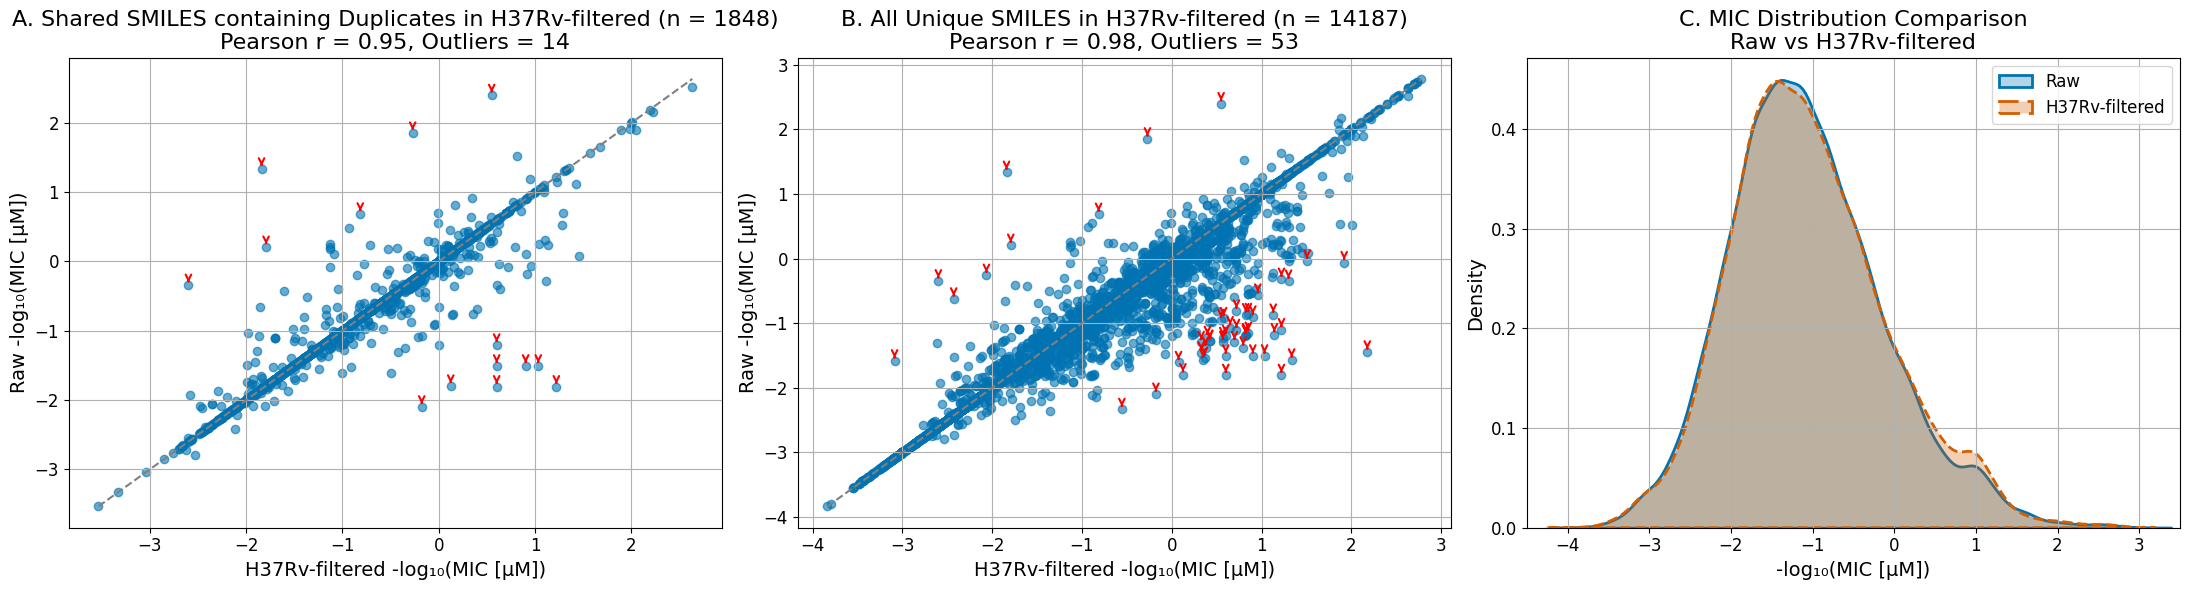

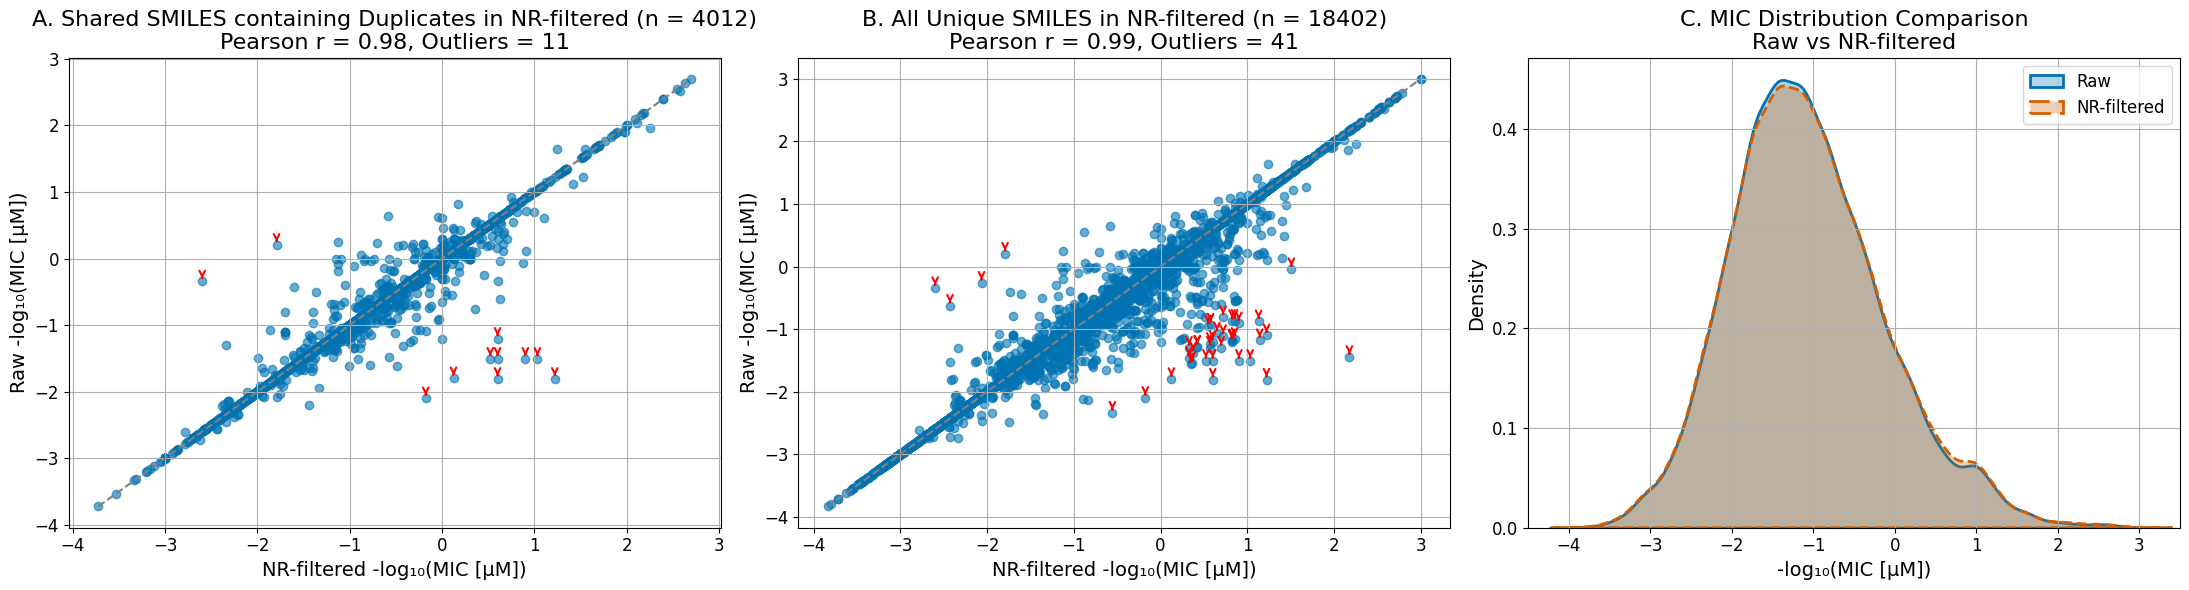

In [42]:
# LLM vs Raw
compare_datasets(h37rv_filtered_data, raw_data, ds1_label="H37Rv-filtered", ds2_label="Raw", output_path="h37rv_vs_raw_logMIC.png")

# NR vs Raw
compare_datasets(nr_filtered_data, raw_data, ds1_label="NR-filtered", ds2_label="Raw", output_path="nr_vs_raw_logMIC.png")

In [43]:
def compare_medians(ds1, ds2, ds1_label="DS1", ds2_label="Raw", output_path="comparison_plot_medianMIC.png"):
    # Keep only relevant columns
    cols = ["canonical_smiles", "MIC_uM_median"]
    ds1 = ds1[cols].dropna()
    ds2 = ds2[cols].dropna()

    # Rename for merging clarity
    ds1 = ds1.rename(columns={"MIC_uM_median": "mic_median_ds1"})
    ds2 = ds2.rename(columns={"MIC_uM_median": "mic_median_ds2"})

    # Plot A and B — shared and unique SMILES
    merged_dups_only = pd.merge(ds1, ds2, on="canonical_smiles")

    fig, axs = plt.subplots(1, 3, figsize=(22, 6))

    # Plot A: Shared SMILES with duplicates (just rename label)
    r_dups = safe_pearson(merged_dups_only["mic_median_ds1"], merged_dups_only["mic_median_ds2"])
    n_dups = len(merged_dups_only)
    axs[0].scatter(merged_dups_only["mic_median_ds1"], merged_dups_only["mic_median_ds2"], alpha=0.6)
    lims = [
        min(merged_dups_only["mic_median_ds1"].min(), merged_dups_only["mic_median_ds2"].min()),
        max(merged_dups_only["mic_median_ds1"].max(), merged_dups_only["mic_median_ds2"].max())
    ]
    axs[0].plot(lims, lims, '--', color='gray')
    n_outliers = annotate_outliers(axs[0], merged_dups_only, "mic_median_ds1", "mic_median_ds2", threshold=10)
    axs[0].set_title(f"A. Shared SMILES (n = {n_dups})\nPearson r = {r_dups:.2f}, Outliers = {n_outliers}")
    axs[0].set_xlabel(f"{ds1_label} MIC median [µM]")
    axs[0].set_ylabel(f"{ds2_label} MIC median [µM]")
    axs[0].grid(True)

    # Plot B: Same data, used again
    axs[1].scatter(merged_dups_only["mic_median_ds1"], merged_dups_only["mic_median_ds2"], alpha=0.6)
    axs[1].plot(lims, lims, '--', color='gray')
    n_outliers_b = annotate_outliers(axs[1], merged_dups_only, "mic_median_ds1", "mic_median_ds2", threshold=10)
    axs[1].set_title(f"B. All Overlapping SMILES (n = {n_dups})\nOutliers = {n_outliers_b}")
    axs[1].set_xlabel(f"{ds1_label} MIC median [µM]")
    axs[1].set_ylabel(f"{ds2_label} MIC median [µM]")
    axs[1].grid(True)


    # Plot C: KDE of MIC medians
    palette = sns.color_palette("colorblind")
    sns.kdeplot(
        ds2["mic_median_ds2"],
        label=ds2_label,
        fill=True,
        alpha=0.3,
        linewidth=2,
        ax=axs[2],
        color=palette[0]
    )
    sns.kdeplot(
        ds1["mic_median_ds1"],
        label=ds1_label,
        fill=True,
        alpha=0.3,
        linewidth=2,
        linestyle="--",
        ax=axs[2],
        color=palette[3]
    )
    axs[2].set_title(f"C. MIC Median Distribution\n{ds2_label} vs {ds1_label}")
    axs[2].set_xlabel("MIC median [µM]")
    axs[2].set_ylabel("Density")
    axs[2].legend(loc="upper right")
    axs[2].grid(True)

    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.show()


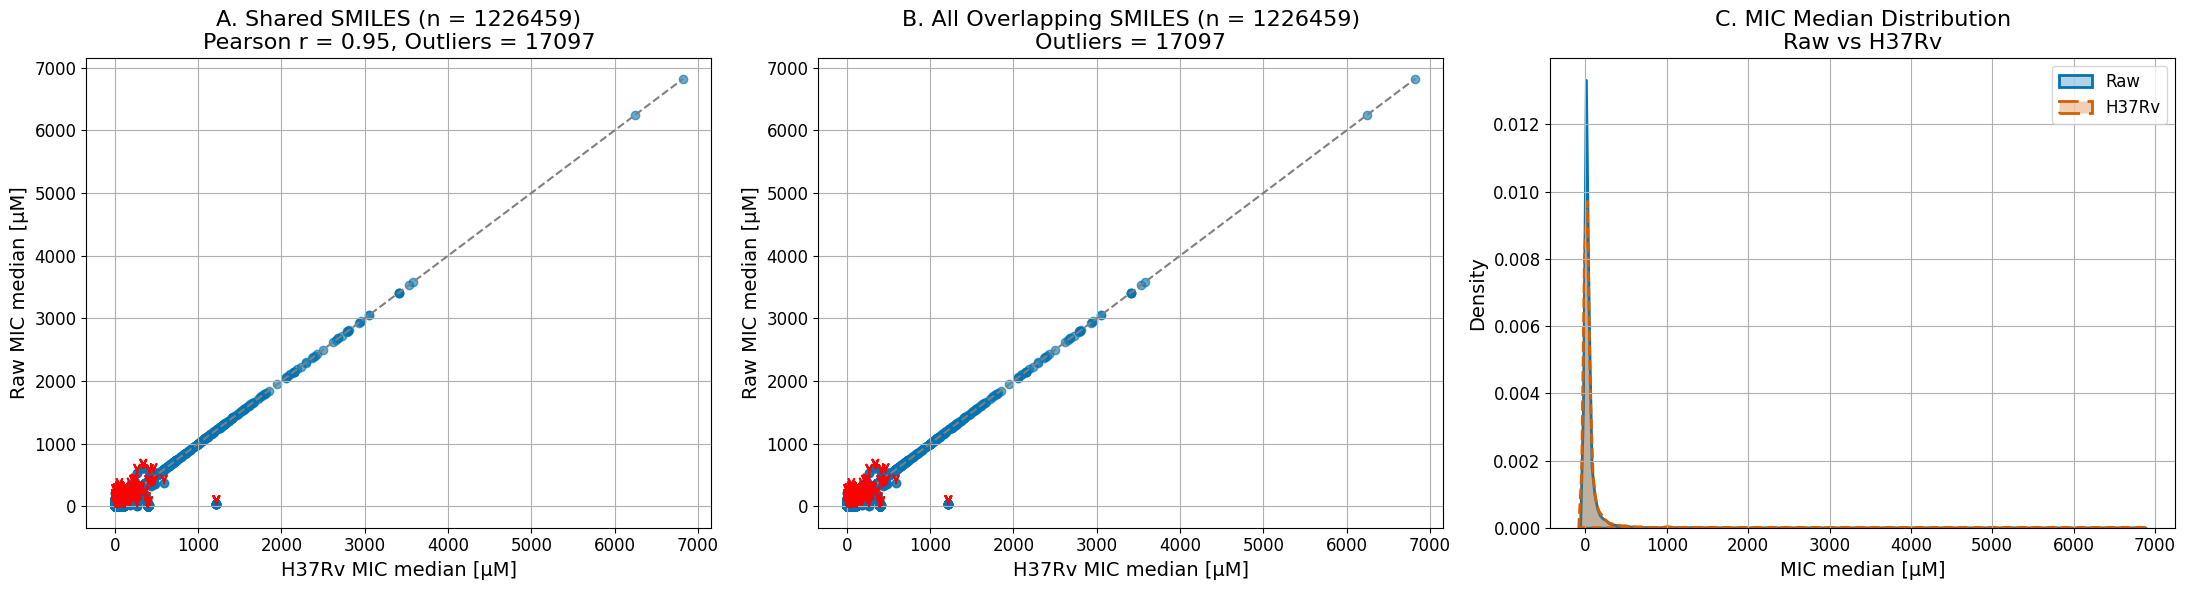

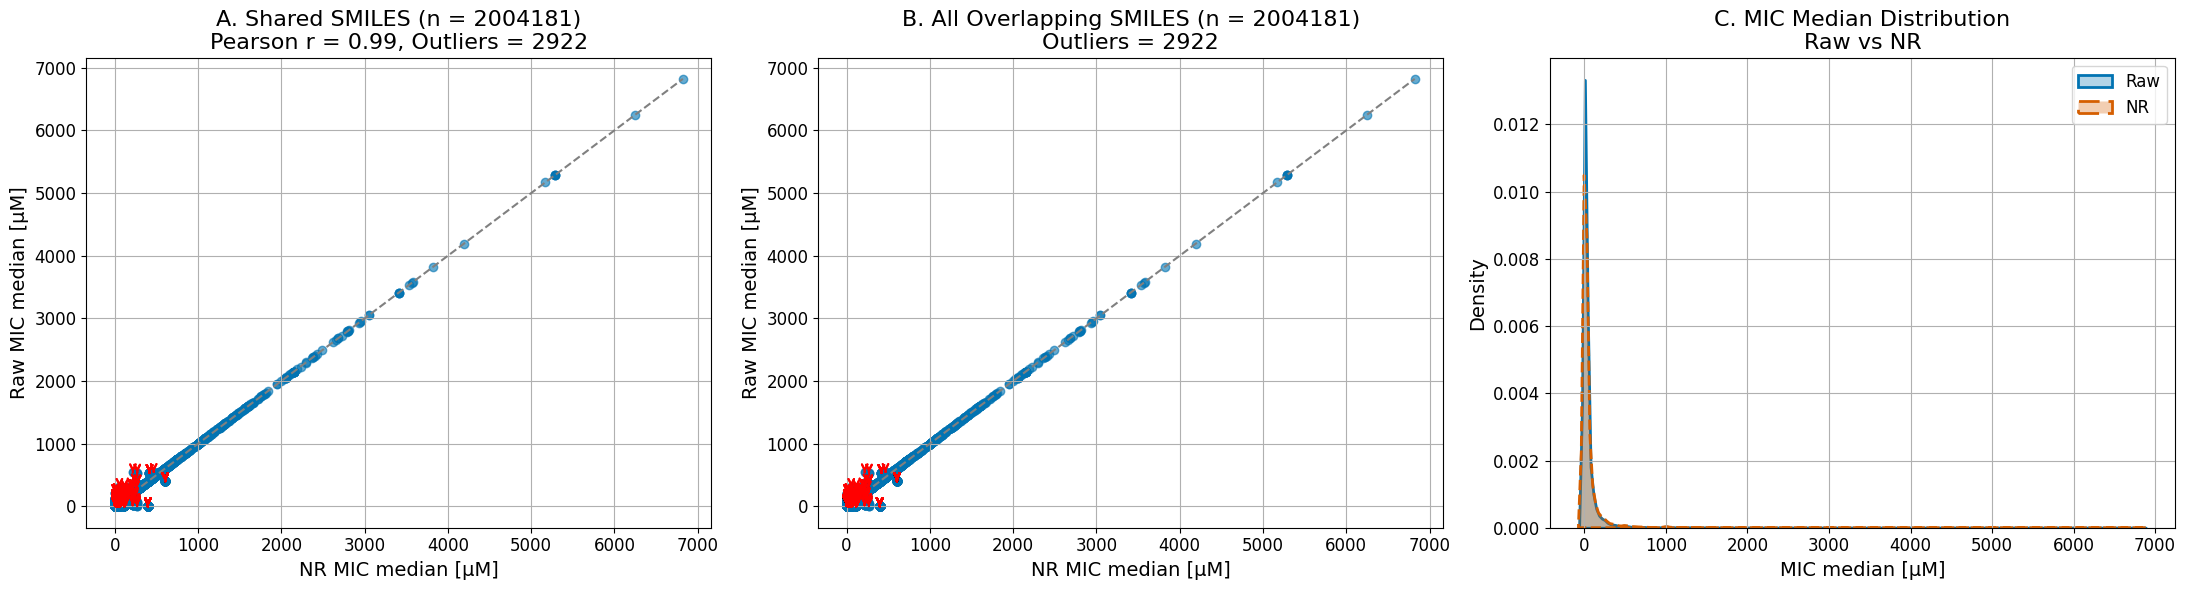

In [44]:
compare_medians(h37rv_filtered_data, raw_data, ds1_label="H37Rv", ds2_label="Raw", output_path="llm_vs_raw_medians.png")
compare_medians(nr_filtered_data, raw_data, ds1_label="NR", ds2_label="Raw", output_path="nr_vs_raw_medians.png")


In [99]:
import pandas as pd
import os


import pandas as pd
import numpy as np
import sys
sys.path.append('../..')
from utils import convert_to_uM

test_df = pd.read_csv('/home/malves/predinhib_mtb/data/cv/raw_h37rv_nr/folds/h37rv/h37rv_rep0_fold0.csv')

val_df = pd.read_csv('/home/malves/predinhib_mtb/data/cv/raw_h37rv_nr/folds/h37rv/h37rv_rep0_fold1.csv')

import glob
# Directory containing all rep0 fold CSVs
fold_dir = "/home/malves/predinhib_mtb/data/cv/raw_h37rv_nr/folds/h37rv"

# Find all rep0 folds excluding fold0 (test)
train_files = sorted(glob.glob(os.path.join(fold_dir, "h37rv_rep0_fold[2-4].csv")))


# Load and concatenate into a single training DataFrame
train_df = pd.concat([pd.read_csv(f) for f in train_files], ignore_index=True)

# Only keep the necessary columns
train_df = train_df[["smiles", "label"]]
val_df = val_df[["smiles", "label"]]
test_df = test_df[["smiles", "label"]]


In [80]:
# from sklearn.model_selection import train_test_split

# def split_train_val(df, val_size=0.2, random_state=42):
#     train, val = train_test_split(df, test_size=val_size, random_state=random_state)
#     return train, val

In [81]:
train_llm = train_df
val_llm = val_df  # already loaded from rep0_fold1

test_llm = test_df  # already loaded from rep0_fold0

In [65]:
data_to_kpgt = pd.concat([train_llm, val_llm]) 

#join test to data_to_kpgt
data_to_kpgt = pd.concat([data_to_kpgt, test_llm])

#save to csv file only smiles and pMIC and change pmic column name to Class and Smiles to smiles
data_to_kpgt[['smiles', 'label']].rename(columns={'mic_log': 'Class', 'smiles': 'smiles'}).to_csv('/home/malves/predator/KPGT/datasets/tb_regression/tb_regression.csv', index=False)

In [11]:
import subprocess
import datetime
import os

#create unique directory name function
def unique_dir_name():
    now = datetime.datetime.now()
    return str(now.strftime("%d-%m-%Y_%H-%M-%S"))


def smiles_to_embeddings(smiles, gpu):
    folder = unique_dir_name()
    dataset_path = '/home/malves/predator/KPGT/datasets/' + folder + '/'
    os.makedirs(dataset_path)
    #create df to store class and smiles
    activity = [0]*len(smiles)
    df = pd.DataFrame({'Class': activity, 'smiles': smiles})
    df.to_csv(f'/home/malves/predator/KPGT/datasets/{folder}/{folder}.csv', index=False)

    
    # Store the original working directory
    original_path = os.getcwd()

    # Set the script path, data path, and folder
    script_path = '/home/malves/predator/KPGT/scripts/preprocess_downstream_dataset.py'

    # Change the working directory to the directory containing the script
    os.chdir(os.path.dirname(script_path))

    try:
        cmd = ['/home/malves/miniconda3/envs/KPGT/bin/python', '/home/malves/predator/KPGT/scripts/preprocess_downstream_dataset.py', '--data_path', '/home/malves/predator/KPGT/datasets', '--dataset', folder]
        subprocess.run(cmd)

        print('Extracting features...')
        
        cmd = ['/home/malves/miniconda3/envs/KPGT/bin/python', '/home/malves/predator/KPGT/scripts/extract_features.py', '--config', 'base', '--model_path', '/home/malves/predator/KPGT/models/pretrained/base/base.pth', '--data_path', '/home/malves/predator/KPGT/datasets/', '--gpu', str(gpu), '--dataset', folder]
        subprocess.run(cmd)

    finally:
        # Revert the working directory to its original state
        os.chdir(original_path)

    data = np.load(f'/home/malves/predator/KPGT/datasets/{folder}/kpgt_base.npz')

    fps_array = data['fps']

    #remove folder of dataset_path
    os.system(f'rm -r /home/malves/predator/KPGT/datasets/{folder}')

    return fps_array

In [12]:
smiles = data_to_kpgt.smiles.values


fps = smiles_to_embeddings(smiles, gpu=6)

Using backend: pytorch
[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.


constructing graphs


Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorchUsing backend: pytorch

Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorchUsing backend: pytorch

Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorchUsing backend: pytorchUsing backend: pytorch


Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorchUsing backend: pytorch

Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    3.0s
[Parallel(n_jobs=32)]: Done 936 tasks      | elapsed:    4.2s
[Parallel(n_jobs=32)]: Done 2336 tasks      | elapsed:    6.2s
[Parallel(n_jobs=32)]: Done 4136 tasks      | elapsed:    9.4s
[Parallel(n_jo

saving graphs
extracting fingerprints
saving fingerprints
extracting molecular descriptors
Extracting features...187/14187


Using backend: pytorch


The extracted features were saved at /home/malves/predator/KPGT/datasets//18-04-2025_14-58-40/kpgt_base.npz


In [100]:
train=train_llm
val=val_llm
test=test_llm

In [101]:
x_train = train['smiles'].values
y_train = train['label'].values

x_val = val['smiles'].values
y_val = val['label'].values

x_test = test['smiles'].values
y_test = test['label'].values

In [102]:
#fps_array = data['fps']
fps_array = fps
train_fps = fps_array[:len(x_train)]
val_fps = fps_array[len(x_train): len(x_train)+len(x_val)]
test_fps = fps_array[len(x_train)+ len(x_val):]

In [103]:
-np.log10(16)

np.float64(-1.2041199826559248)

In [104]:
import numpy as np

# Convert labels to binary
y_train = np.where(y_train <= -np.log10(16), 1, 0)
y_val = np.where(y_val <= -np.log10(16), 1, 0)
y_test = np.where(y_test <= -np.log10(16), 1, 0)

# Print label balances
def print_label_balance(name, labels):
    unique, counts = np.unique(labels, return_counts=True)
    print(f"{name} label balance:")
    for label, count in zip(unique, counts):
        print(f"  Class {label}: {count} ({count / len(labels):.2%})")
    print()

print_label_balance("Train", y_train)
print_label_balance("Validation", y_val)
print_label_balance("Test", y_test)

Train label balance:
  Class 0: 4745 (54.00%)
  Class 1: 4042 (46.00%)

Validation label balance:
  Class 0: 1352 (51.50%)
  Class 1: 1273 (48.50%)

Test label balance:
  Class 0: 1436 (51.75%)
  Class 1: 1339 (48.25%)



In [105]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
import numpy as np

class MoleculeDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

In [106]:
# Convert data to PyTorch tensors
train_embeddings = torch.tensor(train_fps, dtype=torch.float32)
train_labels = torch.tensor(y_train, dtype=torch.float32)

val_embeddings = torch.tensor(val_fps, dtype=torch.float32)
val_labels = torch.tensor(y_val, dtype=torch.float32)

test_embeddings = torch.tensor(test_fps, dtype=torch.float32)
test_labels = torch.tensor(y_test, dtype=torch.float32)

# Create data loaders
train_dataset = MoleculeDataset(train_embeddings, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = MoleculeDataset(val_embeddings, val_labels)
val_loader = DataLoader(val_dataset, batch_size=32)

test_dataset = MoleculeDataset(test_embeddings, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32)

In [107]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from pytorch_lightning.loggers import TensorBoardLogger  # Corrected import
from sklearn.metrics import mean_squared_error, r2_score

from torch.optim.lr_scheduler import ReduceLROnPlateau


class MoleculeClassifier(pl.LightningModule):
    def __init__(self, input_size=2304, hidden_size1=1024, hidden_size2=512, hidden_size3=256, hidden_size4=128, output_size=1):
        super(MoleculeClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.BatchNorm1d(hidden_size1),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size1, hidden_size2),
            nn.BatchNorm1d(hidden_size2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size2, hidden_size3),
            nn.BatchNorm1d(hidden_size3),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size3, hidden_size4),
            nn.BatchNorm1d(hidden_size4),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(hidden_size4, output_size),
            nn.Sigmoid()
        )

        self.train_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []
        self.train_losses = []
        self.val_losses = []
        self.test_losses = [] 
        self.loss_function = nn.BCELoss()

    def forward(self, x):
        return self.model(x)

    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return {'optimizer': optimizer, 'monitor': 'val_loss'}
    

    def training_step(self, batch, batch_idx):
        self.train()  # Switch to training mode
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.loss_function(outputs, targets.view(-1, 1).float())
        self.train_step_outputs.append(loss)
        return {'loss': loss}
    
    def on_train_epoch_end(self):
        avg_train_loss = torch.stack(self.train_step_outputs).mean()
        self.train_losses.append(avg_train_loss.item())
        self.train_step_outputs.clear()
        self.log('train_loss', avg_train_loss)
        print(f'Train loss: {avg_train_loss}')

    def validation_step(self, batch, batch_idx):
        self.eval()
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.loss_function(outputs, targets.view(-1, 1).float())
        self.validation_step_outputs.append(loss)
        return {'val_loss': loss}
    
    def on_validation_epoch_end(self):
        avg_val_loss = torch.stack(self.validation_step_outputs).mean()
        self.val_losses.append(avg_val_loss.item())
        self.validation_step_outputs.clear()
        self.log('val_loss', avg_val_loss)
        print(f'Validation loss: {avg_val_loss}')
        self.train()


    def test_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.loss_function(outputs, targets.view(-1, 1).float())
        return {'test_loss': loss}
    
    def on_test_epoch_end(self):
        avg_test_loss = torch.stack(self.test_step_outputs).mean()
        self.test_losses.append(avg_test_loss.item())
        self.test_step_outputs.clear()
        self.log('test_loss', avg_test_loss)
    
    



In [108]:
    
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping

import datetime

time_stamp = datetime.datetime.now().strftime("%d-%m-%Y_%H-%M-%S")


# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='/home/malves/predator/notebooks/classifiers/h37rv/saved_models/classification/kpgt/chembl',
    filename=f'best_model_tb_class{time_stamp}',
    save_top_k=1,
    mode='min',
)


early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Metric to monitor for early stopping
    patience=10,           # Number of epochs with no improvement after which training will be stopped
    mode='min'            # 'min' if the metric should be minimized, 'max' if it should be maximized
)

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger

# Create the Lightning Trainer with the TensorBoardLogger callback
trainer = pl.Trainer(max_epochs=100, 
                     callbacks=[checkpoint_callback, early_stopping_callback],
                     accelerator="gpu")  

model = MoleculeClassifier()
trainer.fit(model, train_loader, val_loader)

Trainer will use only 1 of 7 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=7)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6]

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | model         | Sequential | 3.1 M  | train
1 | loss_function | BCELoss    | 0      | train
-----------------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.213    Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/malves/miniconda3/envs/predinhib/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.


Validation loss: 0.700090765953064


/home/malves/miniconda3/envs/predinhib/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.7550751566886902
Train loss: 0.5675429701805115


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.782929539680481
Train loss: 0.4937158226966858


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.8292514681816101
Train loss: 0.4639822840690613


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.8059877753257751
Train loss: 0.44041427969932556


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.7880733013153076
Train loss: 0.43282222747802734


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.787981390953064
Train loss: 0.4156460464000702


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.8884624242782593
Train loss: 0.40556803345680237


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.8420830965042114
Train loss: 0.38860026001930237


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.8874204158782959
Train loss: 0.38077113032341003


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.9225647449493408
Train loss: 0.3768838942050934


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.8843433856964111
Train loss: 0.3682004511356354


In [25]:
# #plot train and val losses
# plt.figure(figsize=(10, 10))
# plt.plot(model.train_losses, label='Training Loss')
# plt.plot(model.val_losses, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Training and Validation Losses')
# plt.show()


In [ ]:
# Load the best model from the checkpoint
best_model = MoleculeClassifier.load_from_checkpoint(f'/home/malves/predator/notebooks/classifiers/h37rv/saved_models/classification/kpgt/chembl/best_model_tb_class{time_stamp}.ckpt', input_size=2304)


best_model.eval()
best_model.to("cuda")

with torch.no_grad():
    test_embeddings = test_embeddings.to("cuda")
    predictions = best_model(test_embeddings).cpu().numpy()

predictions = predictions.reshape(-1)
y_test = y_test.reshape(-1)

predictions.shape, y_test.shape

(2775,) (2775,) (2775,)


In [ ]:
# print accuracy
print(f'Accuracy: {accuracy_score(y_test, np.round(predictions))}')

# print precision
print(f'Precision: {precision_score(y_test, np.round(predictions))}')

# print recall
print(f'Recall: {recall_score(y_test, np.round(predictions))}')

# print f1-score
print(f'F1-Score: {f1_score(y_test, np.round(predictions))}')

# print matthews correlation coefficient
print(f'MCC: {matthews_corrcoef(y_test, np.round(predictions))}')

Accuracy: 0.5610810810810811
F1 Score: 0.6014397905759162
Precision: 0.5352358765288293
Recall: 0.6863330843913368
ROC AUC: 0.6137500234033214


In [46]:
#get metrics for test set
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
mae = np.mean(np.abs(predictions - y_test))

#pearson correlation
import scipy.stats as stats
pearson_corr = stats.pearsonr(y_test, predictions)

print(f'MSE: {mse}')
print(f'R2: {r2}')
print(f'MAE: {mae}')
print(f'Pearson Correlation: {pearson_corr}')

MSE: 1.3062173128128052
R2: -4.231260776519775
MAE: 0.8750701654883656
Pearson Correlation: PearsonRResult(statistic=np.float64(0.16971627888029986), pvalue=np.float64(2.222344943580456e-19))


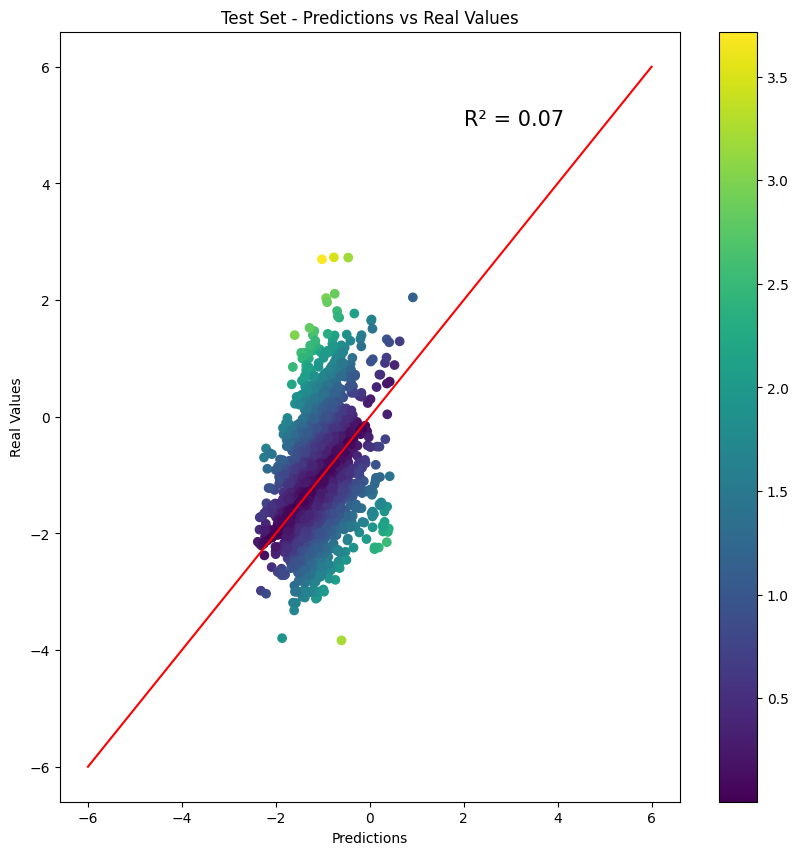

In [34]:
#plot predictions vs real values and paint based on how far they are from y=x line
plt.figure(figsize=(10,10))
plt.scatter(predictions, y_test, c=np.abs(predictions - y_test))
#add rsquare to plot
plt.text(2, 5, f'R\u00b2 = {r2_score(y_test, predictions):.2f}', fontsize=15)

#draw line y=x
plt.plot([-6, 6], [-6, 6], color='red')

#add colorbar
plt.colorbar()
#add labels

plt.xlabel('Predictions')
plt.ylabel('Real Values')
plt.title('Test Set - Predictions vs Real Values')
plt.show()

In [120]:
from sklearn.svm import SVR
# Create the SVR model
svr_regressor = SVR()

# Train the SVR model
svr_regressor.fit(train_fps, y_train)

# Predict the test set
svr_predictions = svr_regressor.predict(test_fps)

# Calculate the metrics
svr_mse = mean_squared_error(y_test, svr_predictions)
svr_r2 = r2_score(y_test, svr_predictions)
svr_mae = np.mean(np.abs(svr_predictions - y_test))

# Calculate the Pearson correlation
svr_pearson_corr = stats.pearsonr(y_test, svr_predictions)

print(f'SVR MSE: {svr_mse}')
print(f'SVR R2: {svr_r2}')
print(f'SVR MAE: {svr_mae}')
print(f'SVR Pearson Correlation: {svr_pearson_corr}')

SVR MSE: 0.35811524671616396
SVR R2: 0.5884442880940111
SVR MAE: 0.4358349490488752
SVR Pearson Correlation: PearsonRResult(statistic=np.float64(0.767388859722283), pvalue=np.float64(0.0))


In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from rdkit import Chem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

# === ECFP fingerprint generation ===
def smiles_to_ecfp(smiles_list, radius=2, nBits=2048):
    gen = GetMorganGenerator(radius=radius, fpSize=nBits)
    fps = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            fp = gen.GetFingerprint(mol)
            fps.append(np.array(fp))
        else:
            fps.append(np.zeros(nBits))
    return np.array(fps)

# === Prepare data ===
def prepare_data(df):
    X = smiles_to_ecfp(df["canonical_smiles"])
    y = df["mic_log"].astype(float)
    return X, y

# === RMSE scorer ===
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# === Scoring setup ===
scoring = {
    'R2': make_scorer(r2_score),
    'MAE': make_scorer(mean_absolute_error),
    'RMSE': make_scorer(rmse)
}

# === Evaluation function for MLP ===
def evaluate_mlp(df, label, hidden_layer_sizes=(128, 64), max_iter=500):
    X, y = prepare_data(df)
    model = MLPRegressor(
        hidden_layer_sizes=hidden_layer_sizes,
        activation="relu",
        solver="adam",
        early_stopping=True,
        max_iter=max_iter,
        random_state=42
    )
    scores = cross_validate(model, X, y, cv=5, scoring=scoring, return_train_score=False)
    print(f"🧠 MLP Regression - {label}")
    print(f"  R²   : {np.mean(scores['test_R2']):.3f}")
    print(f"  MAE  : {np.mean(scores['test_MAE']):.3f}")
    print(f"  RMSE : {np.mean(scores['test_RMSE']):.3f}")
    print("-" * 40)
    return scores

# === Run MLP benchmarks ===
evaluate_mlp(raw_data_no_duplicates, "Raw Data")
evaluate_mlp(llm_filtered_data_no_duplicates, "LLM-Filtered Data")

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import numpy as np
from sklearn.metrics import matthews_corrcoef

# === Add binary activity label ===
def binarize_activity(df, threshold=-0.699):  # 5 µM threshold
    df = df.copy()
    df["label"] = df["mic_log"].apply(lambda x: 1 if x <= threshold else 0)
    return df

# === Prepare data ===
def prepare_data_classification(df):
    X = smiles_to_ecfp(df["canonical_smiles"])
    y = df["label"].astype(int)
    return X, y

# === Scoring ===
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'mcc': make_scorer(matthews_corrcoef)
}

# === Evaluation function ===
def evaluate_rf_classifier(df, label):
    df = binarize_activity(df)
    X, y = prepare_data_classification(df)
    clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    scores = cross_validate(clf, X, y, cv=5, scoring=scoring, return_train_score=False)
    print(f"🌲 Classification - {label}")
    print(f"  Accuracy : {np.mean(scores['test_accuracy']):.3f}")
    print(f"  Precision: {np.mean(scores['test_precision']):.3f}")
    print(f"  Recall   : {np.mean(scores['test_recall']):.3f}")
    print(f"  F1       : {np.mean(scores['test_f1']):.3f}")
    print(f"  MCC      : {np.mean(scores['test_mcc']):.3f}")
    print("-" * 30)

# === Run classification benchmark ===
evaluate_rf_classifier(raw_data_no_duplicates, "Raw Data")
evaluate_rf_classifier(llm_filtered_data_no_duplicates, "LLM-Filtered Data")

🌲 Classification - Raw Data
  Accuracy : 0.672
  Precision: 0.719
  Recall   : 0.853
  F1       : 0.780
  MCC      : 0.170
------------------------------
🌲 Classification - LLM-Filtered Data
  Accuracy : 0.659
  Precision: 0.707
  Recall   : 0.839
  F1       : 0.767
  MCC      : 0.160
------------------------------


In [289]:
def check_class_balance(df, dataset_name, threshold=0.0):
    label_series = df["mic_log"].apply(lambda x: 1 if x >= threshold else 0)
    counts = label_series.value_counts().sort_index()
    total = counts.sum()

    print(f"📊 Class Balance for {dataset_name} (−log10(MIC) ≥ {threshold}):")
    for label, count in counts.items():
        pct = 100 * count / total
        name = "Active" if label == 1 else "Inactive"
        print(f"  {name} (label={label}): {count} compounds ({pct:.1f}%)")
    print("-" * 40)

# Run for threshold = 0.0 (MIC ≤ 1 µM)
check_class_balance(raw_data_no_duplicates, "Raw Data", threshold=-0.699)
check_class_balance(llm_filtered_data_no_duplicates, "LLM-Filtered Data", threshold=-0.699)

📊 Class Balance for Raw Data (−log10(MIC) ≥ -0.699):
  Inactive (label=0): 12890 compounds (68.6%)
  Active (label=1): 5890 compounds (31.4%)
----------------------------------------
📊 Class Balance for LLM-Filtered Data (−log10(MIC) ≥ -0.699):
  Inactive (label=0): 9582 compounds (67.5%)
  Active (label=1): 4605 compounds (32.5%)
----------------------------------------


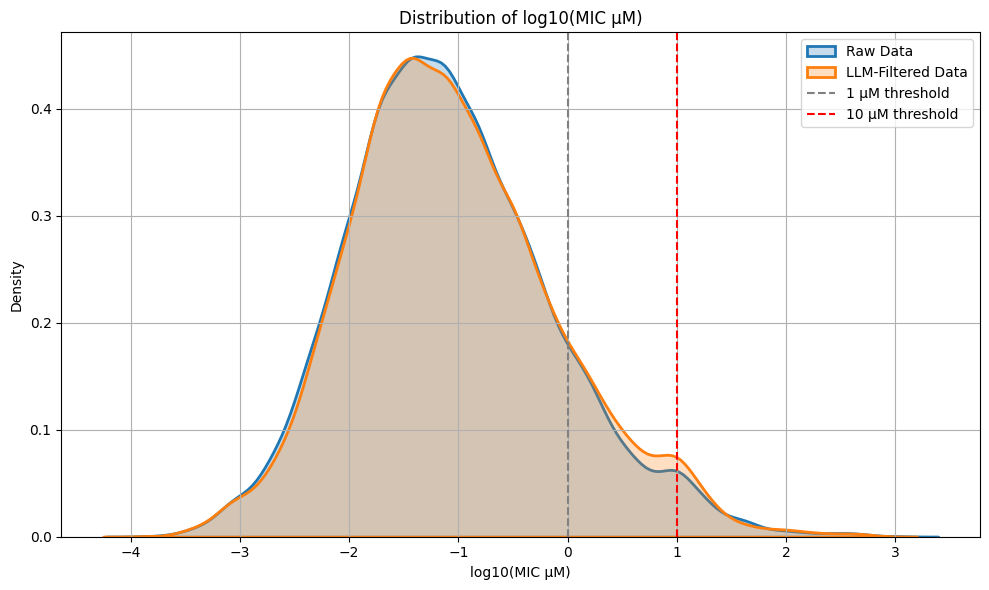

In [265]:
plot_mic_distribution(raw_data_no_duplicates, llm_filtered_data_no_duplicates)